In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()

In [ ]:
df = pd.read_csv('Gujrat 2022-23.newlyedited2.csv')
df = df.set_index('DateTime')
df.index = pd.to_datetime(df.index)

In [ ]:
df.head()

,Date,Time,Power_MW
DateTime,,,
2022-04-01 00:00:00,4-1-2022,00:00,90.93
2022-04-01 00:15:00,4-1-2022,00:15,94.97
2022-04-01 00:30:00,4-1-2022,00:30,108.82
2022-04-01 00:45:00,4-1-2022,00:45,112.58
2022-04-01 01:00:00,4-1-2022,01:00,105.05


In [ ]:
df

,Date,Time,Power_MW
DateTime,,,
2022-04-01 00:00:00,4-1-2022,00:00,90.93
2022-04-01 00:15:00,4-1-2022,00:15,94.97
2022-04-01 00:30:00,4-1-2022,00:30,108.82
2022-04-01 00:45:00,4-1-2022,00:45,112.58
2022-04-01 01:00:00,4-1-2022,01:00,105.05
...,...,...,...
2023-03-31 22:45:00,3-31-2023,22:45,120.56
2023-03-31 23:00:00,3-31-2023,23:00,120.05
2023-03-31 23:15:00,3-31-2023,23:15,110.98


In [ ]:
df.columns

Index(['Date', 'Time', 'Power_MW'], dtype='object')

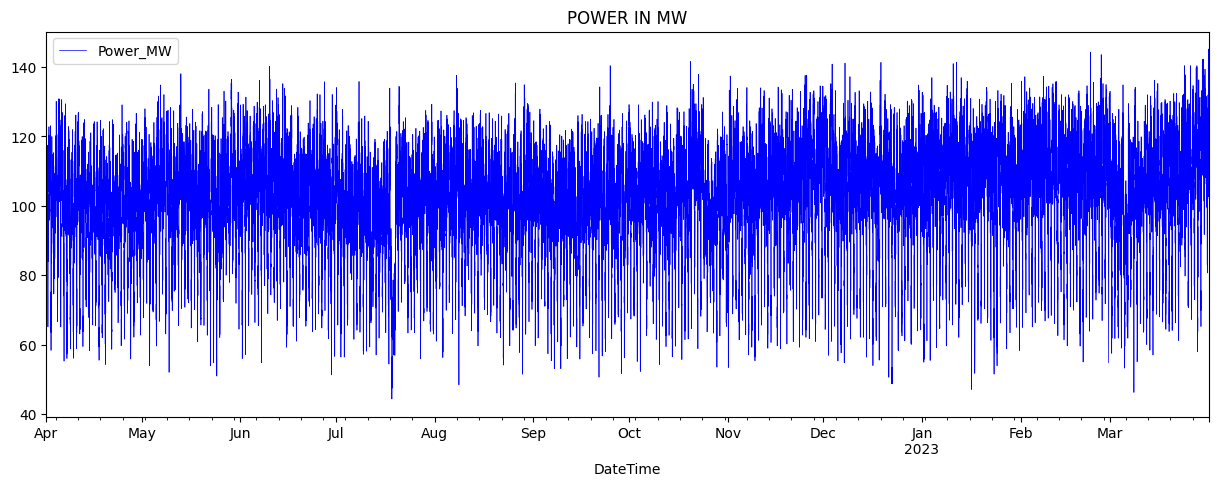

In [ ]:
plot1=df.plot(style='-',figsize=(15,5),color='blue',title='POWER IN MW',lw='0.5')
plt.show()

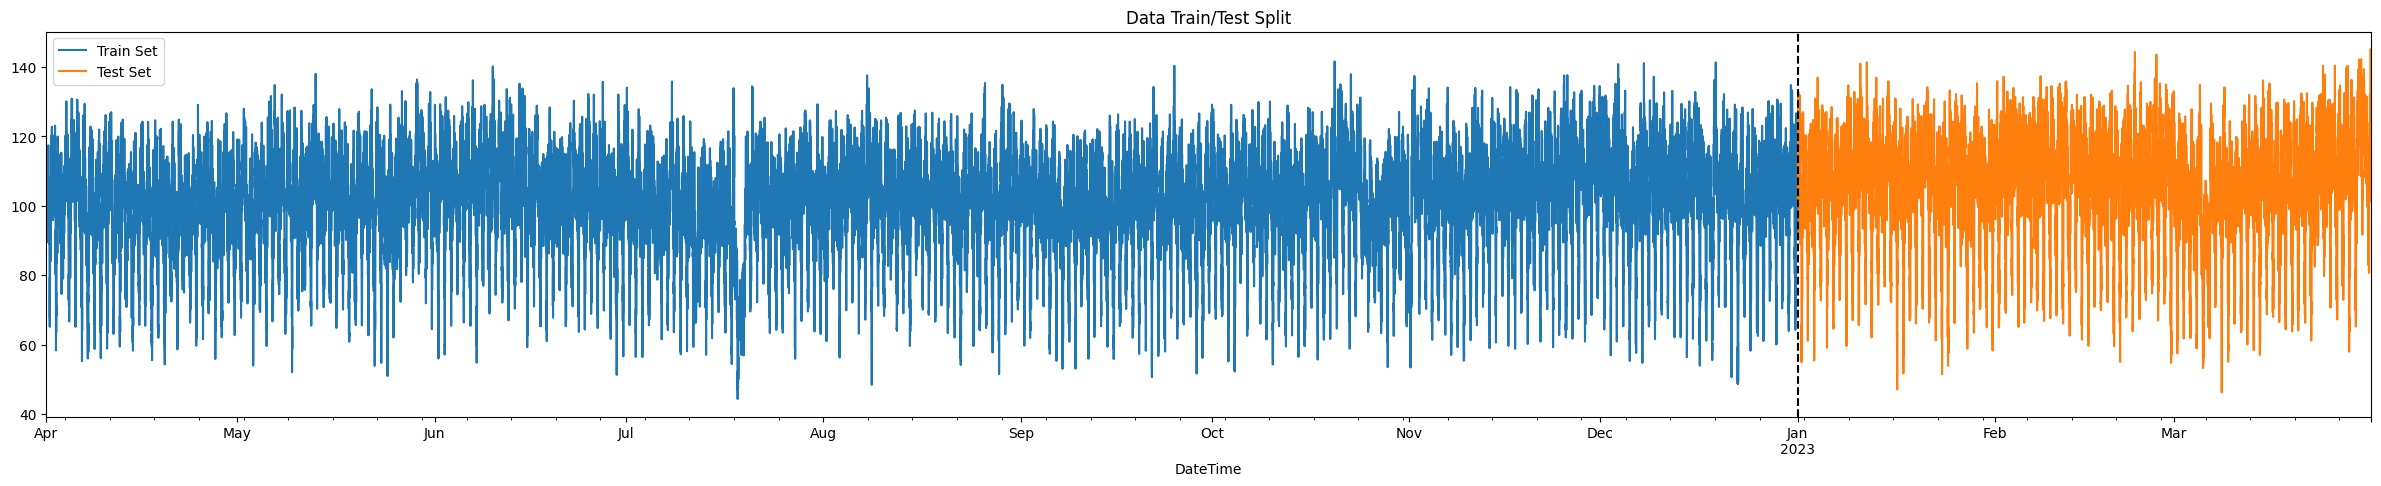

In [ ]:
train = df.loc[df.index < '01-01-2023']
test = df.loc[df.index >= '01-01-2023']
fig, ax = plt.subplots(figsize=(30,5))
train.plot(ax=ax, label='Train Set',title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2023',color='black',ls='--')
ax.legend(['Train Set', 'Test Set'])
plt.show()


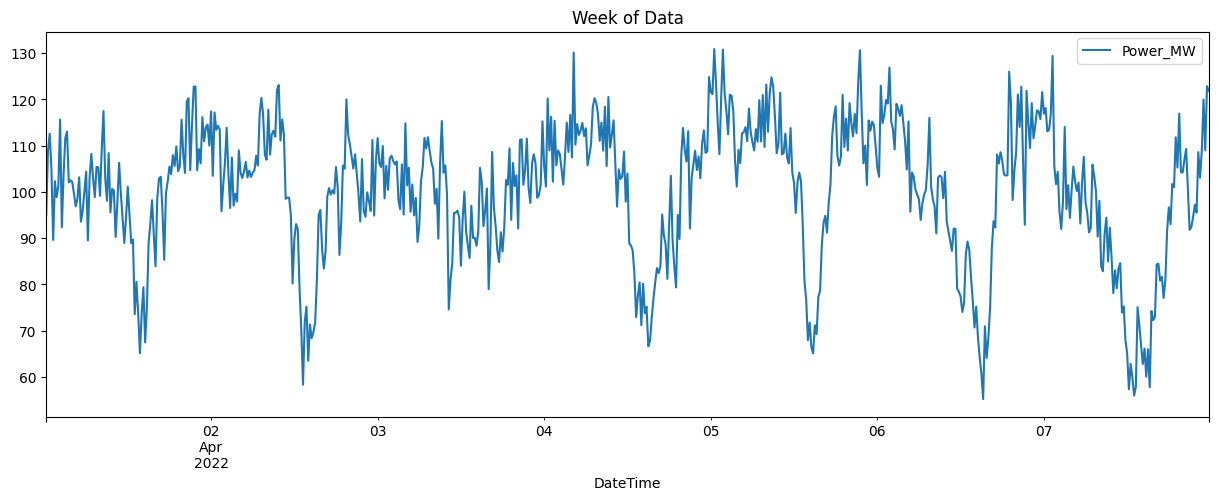

In [ ]:
df.loc[(df.index > '04-01-2022') & (df.index < '04-08-2022')].plot(figsize=(15,5),title='Week of Data',lw='1.5')
plt.show()

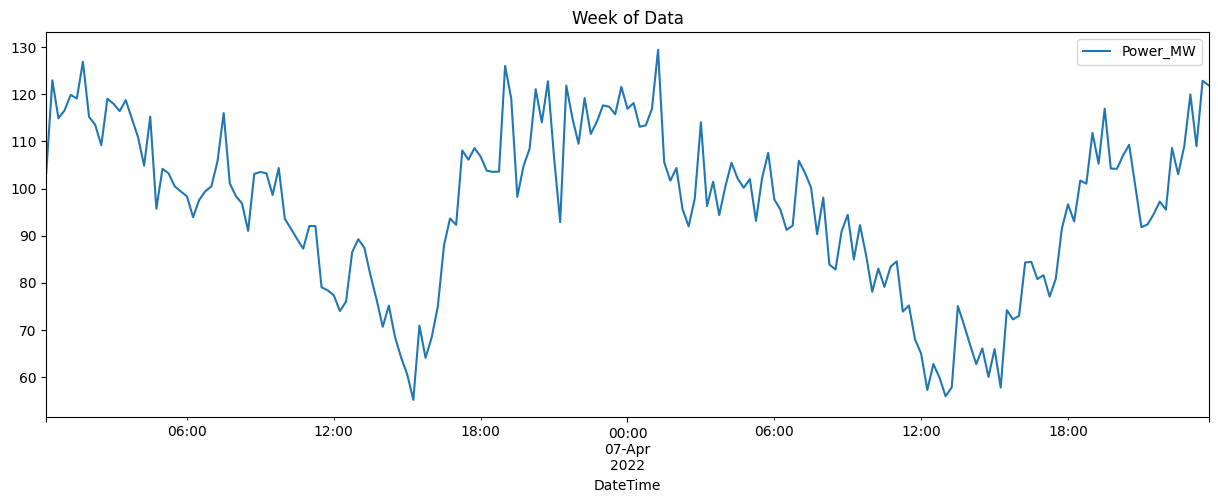

In [ ]:
df.loc[(df.index > '04-06-2022') & (df.index < '04-08-2022')].plot(figsize=(15,5),title='Week of Data',lw='1.5')
plt.show()

In [ ]:
def create_features(df):
    df=df.copy()

    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['Power_MW_15minback']=df['Power_MW'].shift(+1)
    df['Power_MW_30minback']=df['Power_MW'].shift(+2)
    df['Power_MW_1hourback']=df['Power_MW'].shift(+4)

    df['Power_MW_1dayback']=df['Power_MW'].shift(+96)
    df['Power_MW_1weekback']=df['Power_MW'].shift(+672)

    return df

df = create_features(df)

In [ ]:
df

,Date,Time,Power_MW,hour,dayofweek,quarter,month,year,dayofyear,Power_MW_15minback,Power_MW_30minback,Power_MW_1hourback,Power_MW_1dayback,Power_MW_1weekback
DateTime,,,,,,,,,,,,,,
2022-04-01 00:00:00,4-1-2022,00:00,90.93,0,4,2,4,2022,91,NaN,NaN,NaN,NaN,NaN
2022-04-01 00:15:00,4-1-2022,00:15,94.97,0,4,2,4,2022,91,90.93,NaN,NaN,NaN,NaN
2022-04-01 00:30:00,4-1-2022,00:30,108.82,0,4,2,4,2022,91,94.97,90.93,NaN,NaN,NaN
2022-04-01 00:45:00,4-1-2022,00:45,112.58,0,4,2,4,2022,91,108.82,94.97,NaN,NaN,NaN
2022-04-01 01:00:00,4-1-2022,01:00,105.05,1,4,2,4,2022,91,112.58,108.82,90.93,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-31 22:45:00,3-31-2023,22:45,120.56,22,4,1,3,2023,90,129.35,145.22,122.12,125.12,110.77
2023-03-31 23:00:00,3-31-2023,23:00,120.05,23,4,1,3,2023,90,120.56,129.35,117.79,117.58,110.90
2023-03-31 23:15:00,3-31-2023,23:15,110.98,23,4,1,3,2023,90,120.05,120.56,145.22,122.14,102.38


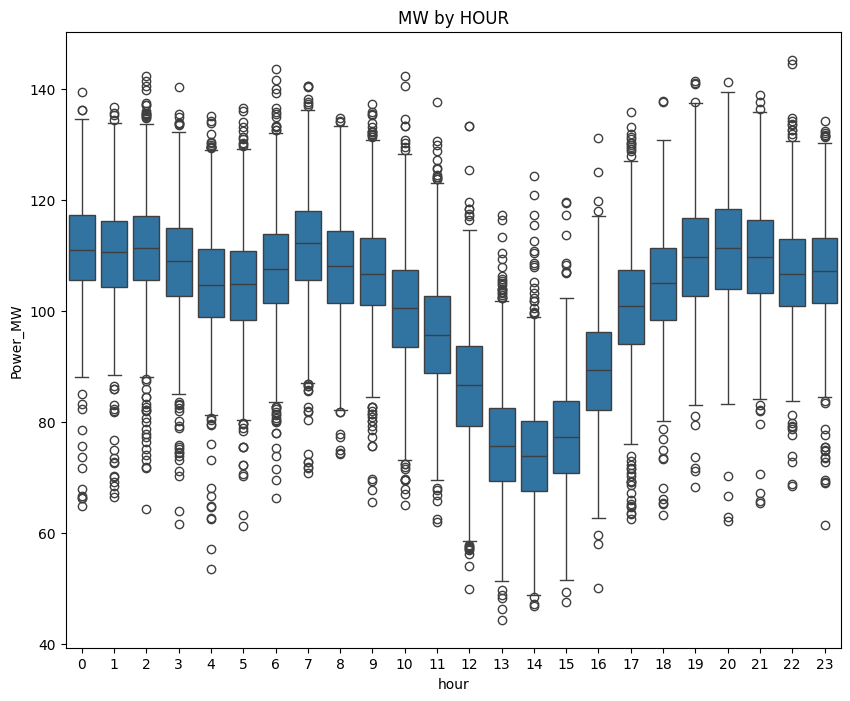

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='hour', y='Power_MW')
ax.set_title('MW by HOUR')
plt.show()

<ipython-input-53-2d50b861a53a>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='month', y='Power_MW',palette='Blues')


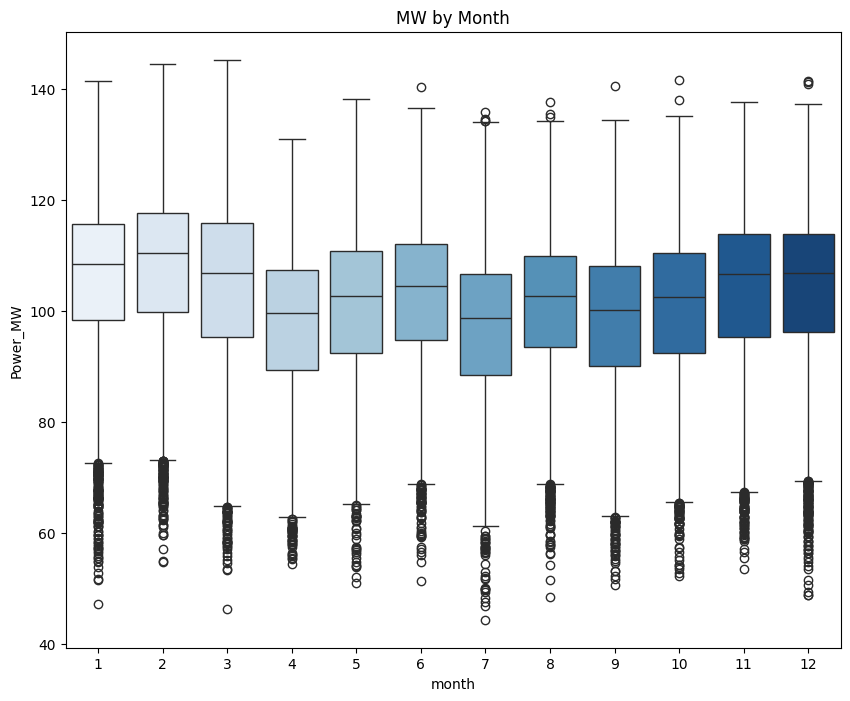

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='month', y='Power_MW',palette='Blues')
ax.set_title('MW by Month')
plt.show()

In [ ]:
df= df.dropna()
df

,Date,Time,Power_MW,hour,dayofweek,quarter,month,year,dayofyear,Power_MW_15minback,Power_MW_30minback,Power_MW_1hourback,Power_MW_1dayback,Power_MW_1weekback
DateTime,,,,,,,,,,,,,,
2022-04-08 00:00:00,4-8-2022,00:00,112.18,0,4,2,4,2022,98,121.88,122.86,119.96,116.91,90.93
2022-04-08 00:15:00,4-8-2022,00:15,112.33,0,4,2,4,2022,98,112.18,121.88,108.98,118.14,94.97
2022-04-08 00:30:00,4-8-2022,00:30,104.86,0,4,2,4,2022,98,112.33,112.18,122.86,113.10,108.82
2022-04-08 00:45:00,4-8-2022,00:45,114.65,0,4,2,4,2022,98,104.86,112.33,121.88,113.42,112.58
2022-04-08 01:00:00,4-8-2022,01:00,117.76,1,4,2,4,2022,98,114.65,104.86,112.18,116.91,105.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-31 22:45:00,3-31-2023,22:45,120.56,22,4,1,3,2023,90,129.35,145.22,122.12,125.12,110.77
2023-03-31 23:00:00,3-31-2023,23:00,120.05,23,4,1,3,2023,90,120.56,129.35,117.79,117.58,110.90
2023-03-31 23:15:00,3-31-2023,23:15,110.98,23,4,1,3,2023,90,120.05,120.56,145.22,122.14,102.38


In [ ]:
#create our model

In [ ]:
train = create_features(train)
test = create_features(test)

In [ ]:
df.columns

Index(['Date', 'Time', 'Power_MW', 'hour', 'dayofweek', 'quarter', 'month',
       'year', 'dayofyear', 'Power_MW_15minback', 'Power_MW_30minback',
       'Power_MW_1hourback', 'Power_MW_1dayback', 'Power_MW_1weekback'],
      dtype='object')

In [ ]:
FEATURES = ['hour', 'Power_MW_15minback', 'Power_MW_30minback',
             'Power_MW_1weekback']
TARGET = 'Power_MW'

In [ ]:
print(FEATURES)

['hour', 'Power_MW_15minback', 'Power_MW_30minback', 'Power_MW_1weekback']


In [ ]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [ ]:
reg = xgb.XGBRegressor(n_estimators=400, early_stopping_rounds=30,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:14.69115	validation_1-rmse:16.63673
[100]	validation_0-rmse:8.56736	validation_1-rmse:9.73649
[200]	validation_0-rmse:7.23951	validation_1-rmse:8.08514
[300]	validation_0-rmse:6.97183	validation_1-rmse:7.71893
[399]	validation_0-rmse:6.88458	validation_1-rmse:7.62319


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=30,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
#feature importance

In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])

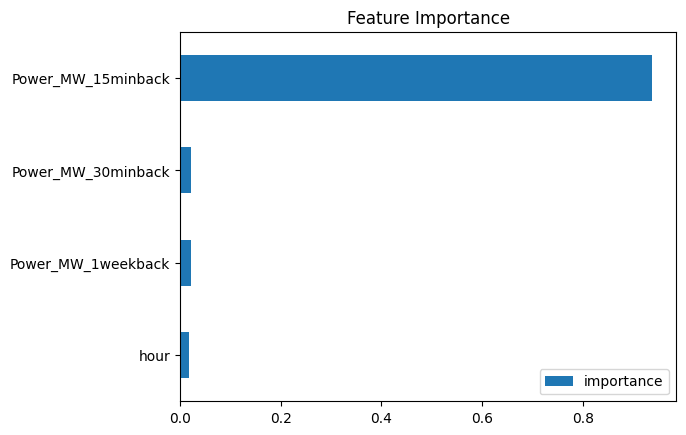

In [ ]:
fi.sort_values('importance').plot(kind='barh',title='Feature Importance')
plt.show()

In [ ]:
#forecast on test

In [ ]:
test['predictions'] = reg.predict(X_test)

In [ ]:
df=df.merge(test[['predictions']], how='left', left_index=True, right_index=True)

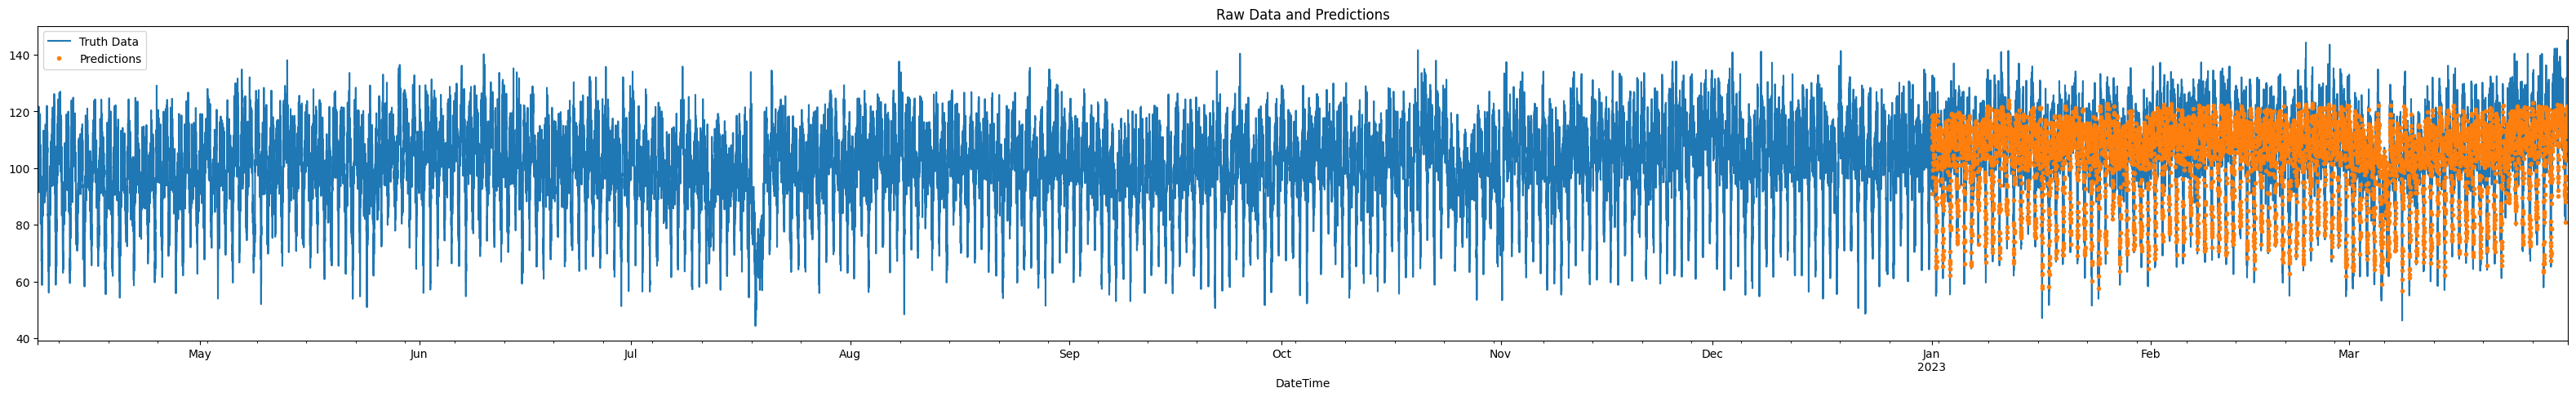

In [ ]:
ax = df[['Power_MW']].plot(figsize=(40,5))
df['predictions'].plot(ax=ax, style='.',lw='0.5')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Predictions')
plt.show()


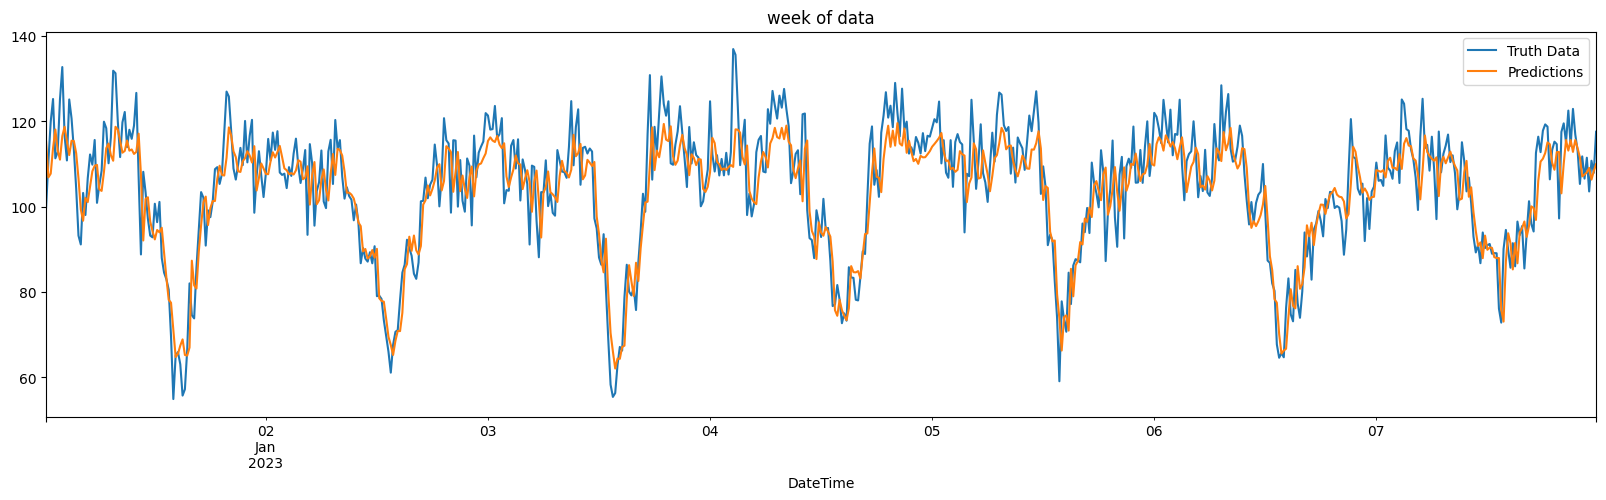

In [ ]:
ax = df.loc[(df.index > '01-01-2023') & (df.index < '01-08-2023')]['Power_MW'] \
     .plot(figsize=(20,5), title='week of data',lw='1.5')
df.loc[(df.index > '01-01-2023') & (df.index < '01-08-2023')]['predictions'] \
     .plot(style='-',lw='1.5')
plt.legend(['Truth Data','Predictions'])
plt.show()

In [ ]:
df['predictions'].dropna()

DateTime
2023-01-01 00:00:00     91.153030
2023-01-01 00:15:00    115.218445
2023-01-01 00:30:00    106.889015
2023-01-01 00:45:00    107.759666
2023-01-01 01:00:00    113.731865
                          ...    
2023-03-31 22:45:00    121.516068
2023-03-31 23:00:00    117.053978
2023-03-31 23:15:00    114.565453
2023-03-31 23:30:00    111.183464
2023-03-31 23:45:00    107.093575
Name: predictions, Length: 8640, dtype: float32

In [ ]:
df


,Date,Time,Power_MW,hour,dayofweek,quarter,month,year,dayofyear,Power_MW_15minback,Power_MW_30minback,Power_MW_1hourback,Power_MW_1dayback,Power_MW_1weekback,predictions
DateTime,,,,,,,,,,,,,,,
2022-04-08 00:00:00,4-8-2022,00:00,112.18,0,4,2,4,2022,98,121.88,122.86,119.96,116.91,90.93,NaN
2022-04-08 00:15:00,4-8-2022,00:15,112.33,0,4,2,4,2022,98,112.18,121.88,108.98,118.14,94.97,NaN
2022-04-08 00:30:00,4-8-2022,00:30,104.86,0,4,2,4,2022,98,112.33,112.18,122.86,113.10,108.82,NaN
2022-04-08 00:45:00,4-8-2022,00:45,114.65,0,4,2,4,2022,98,104.86,112.33,121.88,113.42,112.58,NaN
2022-04-08 01:00:00,4-8-2022,01:00,117.76,1,4,2,4,2022,98,114.65,104.86,112.18,116.91,105.05,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-31 22:45:00,3-31-2023,22:45,120.56,22,4,1,3,2023,90,129.35,145.22,122.12,125.12,110.77,121.516068
2023-03-31 23:00:00,3-31-2023,23:00,120.05,23,4,1,3,2023,90,120.56,129.35,117.79,117.58,110.90,117.053978
2023-03-31 23:15:00,3-31-2023,23:15,110.98,23,4,1,3,2023,90,120.05,120.56,145.22,122.14,102.38,114.565453


In [ ]:
df1=df[['Power_MW','predictions']]
df1

,Power_MW,predictions
DateTime,,
2022-04-08 00:00:00,112.18,NaN
2022-04-08 00:15:00,112.33,NaN
2022-04-08 00:30:00,104.86,NaN
2022-04-08 00:45:00,114.65,NaN
2022-04-08 01:00:00,117.76,NaN
...,...,...
2023-03-31 22:45:00,120.56,121.516068
2023-03-31 23:00:00,120.05,117.053978
2023-03-31 23:15:00,110.98,114.565453


In [ ]:
df1.to_csv("C:\\Users\\hp\\c tutorials\\ML Project Task\\df1.csv")

In [ ]:
score = np.sqrt(mean_squared_error(test['Power_MW'], test['predictions']))
print(f'RMSE Score on the Test set:{score:0.2f}')

RMSE Score on the Test set:7.62


In [ ]:
mape = np.mean(np.abs(test['Power_MW'] - test['predictions']) / test['Power_MW'])*100
print(f'MAPE Score on the Test set:{mape:0.2f}')

MAPE Score on the Test set:5.85


In [ ]:
#calculate error

In [ ]:
test['error'] = np.abs(test[TARGET] - test['predictions'])

In [ ]:
test['date'] = test.index.date

In [ ]:
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2023-03-30    8.554873
2023-03-06    7.439660
2023-03-28    7.305116
2023-03-23    7.225840
2023-02-17    7.207186
2023-02-11    7.052041
2023-02-26    7.043299
2023-03-24    7.029384
2023-03-27    6.908741
2023-01-01    6.823942
Name: error, dtype: float64